# Tutorial: How the sausage is made (cringe)

## Quantitative analysis of hyperspectral data and the fundamentals of algorithm development

Developing algorithms from satellite data need not be left up to experts in satellite oceanography. In fact, it is sometimes useful to have an 'outside' perspective, because this is the building blocks for innovation, and it allows you to explore data for relationships that interest you. If you are sitting on a pile of data that has a latitude, longitude, time, and date associated with it, you have the potential workings of a new data product.

For this exercise, we're going to make use of a public dataset known as The [GLObal Reflectance community dataset for Imaging and optical sensing of Aquatic environments (GLORIA)](https://doi.pangaea.de/10.1594/PANGAEA.948492). Catchy, eh? This dataset includes 7,572 curated hyperspectral remote sensing reflectance measurements at 1 nm intervals within the 350 to 900 nm wavelength range. In addition, at least one co-located water quality measurement of chlorophyll a, total suspended solids, absorption by dissolved substances, and Secchi depth, is provided. 

There are likely some unique spectral patterns here that we can exploit to predict some of these water quality parameters. Let's try to use the hyperspectral nature of PACE to find the best way to describe the patterns we are interested in. An algorithm can be as simple as a + b = c, or it can do some heavy lifting with semi-analytical inversions, or other statistical methods like machine learning. Let's do some exploration.

By the end of this tutorial, you will have:

> 1. Created some useful summary plots of your dataset
> 2. Created and visualized a hyperspectral pairwise correlation matrix
> 3. Found the best 2-band combination to describe your pattern of interest
> 4. Tinkered with a few machine learning techniques (KNN + Random Forest Regression)
> 5. Assessed the performance of your developed algorithms

## *Are you ready?*

# "GLOHHHHRRRIAAH" - Van Morrison 

## Load up the reference data

In [1]:
# === Load Rrs and lab spectra from CSV files ===
import pandas as pd
import numpy as np

# Load the Rrs data (spectral reflectance)
rrs_df = pd.read_csv("GLORIA_Rrs.csv", index_col=0)

# Load the metadata and lab measurements
meta_df = pd.read_csv("GLORIA_meta_and_lab.csv")

For simplicity, let's clean these up since not all reflectance have all 6 water quality measurements associated with them. We'll separate out the individual lab measurements and match them with the corresponding reflectance values.

In [2]:
# --- Clean Rrs data ---
rrs_df.columns = rrs_df.columns.astype(str)  # Ensure strings for stripping
rrs_df.columns = rrs_df.columns.str.replace("Rrs_", "", regex=False).astype(float)

# Filter 400–700 nm
rrs_filtered = rrs_df.loc[:, (rrs_df.columns >= 400) & (rrs_df.columns <= 700)]

# Set index for merging
rrs_filtered.index.name = 'GLORIA_ID'

# --- Clean metadata ---
selected_columns = ['GLORIA_ID', 'Chla', 'Chla_plus_phaeo', 'TSS', 'aCDOM440', 'Turbidity', 'Secchi_depth']
meta_filtered = meta_df[selected_columns].set_index('GLORIA_ID')

# --- Join reflectance and metadata ---
combined_df = rrs_filtered.join(meta_filtered, how='left')

In [3]:
# --- Create cleaned subsets by parameter ---
datasets = {
    param: combined_df.dropna(subset=[param])
    for param in ['Chla', 'Chla_plus_phaeo', 'TSS', 'aCDOM440', 'Turbidity', 'Secchi_depth']
}

## What do we have here?

Let's explore our dataset a little bit. Pay attention to these 4 lines of code. This is where we're going to customize some things that will be used for the rest of the tutorial. First pick your parameter of interest from the six options ('Chla', 'Chla_plus_phaeo', 'TSS', 'aCDOM440', 'Turbidity', 'Secchi_depth'). Set log=true if you want to log transform your data, if not set log=False. The same goes for norm=True if you want to normalize your Rrs data by the area under the curve. This emphasizes absolute spectral shape differences and gets rid of the influence of magnitude. So if you think backscatter might be an important component, maybe set this to False to turn it off. Under sort_by, it defaults to plotting the spectra as a function of your chosen parameter, but you can also set this to the apparent visible wavelength, if you like.

In [4]:
# --- Settings ---
param = 'Chla'        # Parameter to analyze (used for histogram)
log = True            # Apply log transform to histogram?
norm = True           # Normalize Rrs spectra?
sort_by = param       # Sort by 'AVW', 'Chla', or any column in df

Using those parameters, now we're going to plot the remote sensing reflectance, and color code them as a function of your parameter. Let's also look at a histogram of the data, just to get a sense of the range of values we're dealing with. 

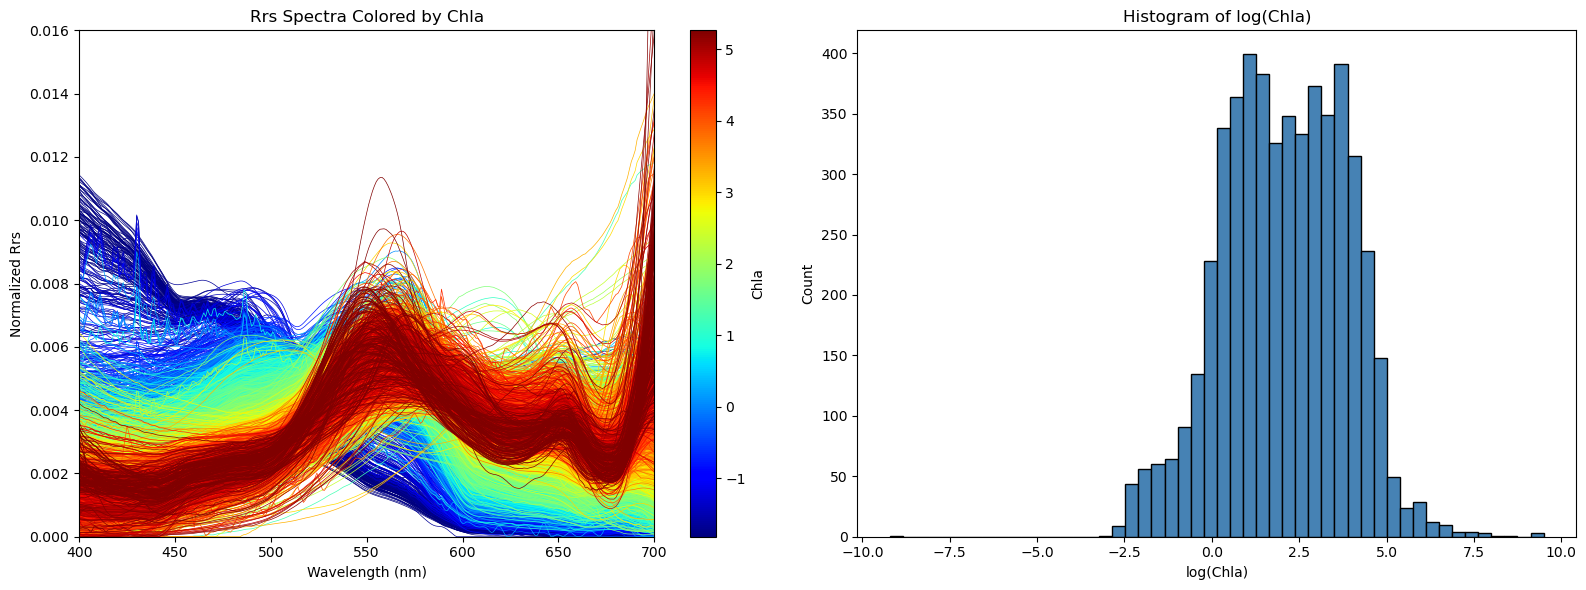

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.integrate import trapezoid

# --- Load and preprocess data ---
df = datasets[param]
rrs_cols = [col for col in df.columns if isinstance(col, float)]
wavelengths = np.array(rrs_cols)
rrs_data = df[rrs_cols].clip(lower=0)

# --- Normalize Rrs spectra ---
if norm:
    area = trapezoid(rrs_data.values, wavelengths, axis=1)
    rrs_data = rrs_data.div(area, axis=0)

# --- Sort by chosen variable ---
rrs_vals = rrs_data.values
sort_var = df[sort_by].values
sort_idx = np.argsort(sort_var)
rrs_vals = rrs_vals[sort_idx]
sort_var = sort_var[sort_idx]

# --- Prepare segments for LineCollection ---
segments = [np.column_stack((wavelengths, row)) for row in rrs_vals]

vmin = np.nanpercentile(sort_var, 2)
vmax = np.nanpercentile(sort_var, 98)
if log:
    color_array = np.log(np.clip(sort_var, 1e-4, None))
    color_label = f"log({sort_by})"
    vmin = np.nanpercentile(color_array, 2)
    vmax = np.nanpercentile(color_array, 98)
else:
    color_array = sort_var
    color_label = sort_by
    vmin = np.nanpercentile(sort_var, 2)
    vmax = np.nanpercentile(sort_var, 98)

line_collection = LineCollection(
    segments, cmap='jet', array=color_array, linewidths=0.5,
    norm=plt.Normalize(vmin=vmin, vmax=vmax)
)

# --- Plot all spectra ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Left plot: Rrs spectra ---
ax1.add_collection(line_collection)
ax1.set_xlim(wavelengths.min(), wavelengths.max())
ax1.set_ylim(0, 0.016)
ax1.set_xlabel("Wavelength (nm)")
ax1.set_ylabel("Normalized Rrs" if norm else "Rrs")
ax1.set_title(f"Rrs Spectra Colored by {sort_by}")

# Add colorbar for ax1
cb = plt.colorbar(line_collection, ax=ax1)
cb.set_label(sort_by)

# --- Right plot: Histogram ---
plot_param = df[param].clip(lower=1e-4)
if log:
    plot_param = np.log(plot_param)

ax2.hist(plot_param, bins=50, color='steelblue', edgecolor='k')
ax2.set_xlabel(f"log({param})" if log else param)
ax2.set_ylabel("Count")
ax2.set_title(f"Histogram of {'log(' + param + ')' if log else param}")

plt.tight_layout()
plt.show()


## What correlates to what

As a start, let's just get an idea of how individual wavelengths of data correlate with your parameter of interest. This is meant to be exploratory at this stage - just a means of maybe finding some low-hanging fruit to exploit. You never know, some algorithms work pretty well with a single color band as input. 

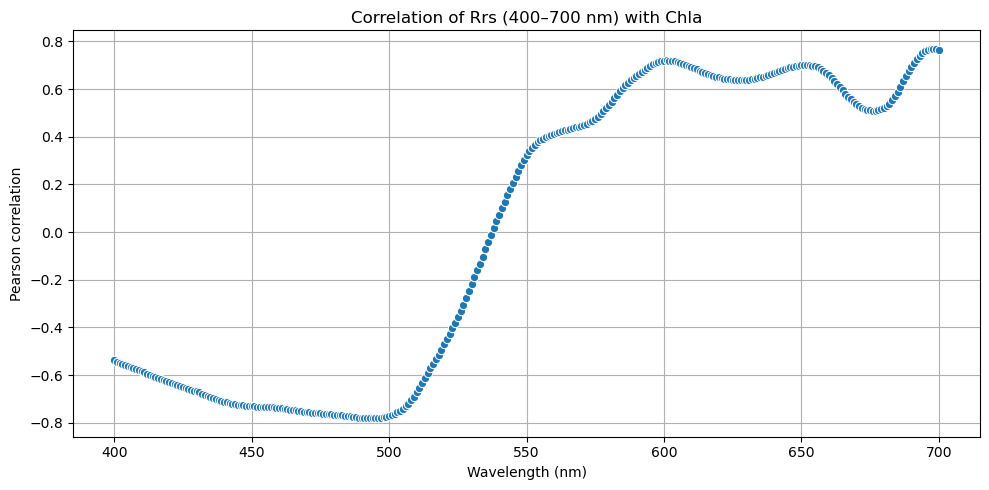

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import trapezoid

# Select cleaned dataset
df = datasets[param]

# Normalize spectrum
area = trapezoid(rrs_data, rrs_cols, axis=1)  # Integrate across rows
spec_norm = rrs_data.div(area, axis=0) if np.any(area > 0) else rrs_data
# Update rrs_data
if norm:
    rrs_data = spec_norm
else:
    rrs_data = df[rrs_cols]

if log:
    target = np.log(df[param].clip(lower=1e-4))
else:
    target = (df[param])

# Compute correlation
correlations = rrs_data.corrwith(target)

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=correlations.index, y=correlations.values, marker='o')
plt.title(f"Correlation of Rrs (400–700 nm) with {param}")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Pearson correlation")
plt.grid(True)
plt.tight_layout()
plt.show()

# Let's make a heat map y'all!

What? It's exciting. We see above how each individual wavelength correlates to our parameter. But what about (wait for it...) TWO wavelengths! You read me right. Let's take a simpel two band algorithm approach. This can be any math combination of two bands. For our case, let's experiment with a normalized difference index (NDI). Because they are fun. 

$NDI = ({\lambda}_{1} - {\lambda}_{2}) / ({\lambda}_{1} + {\lambda}_{2})$

Let's compute every possible NDI that can be computed with the hyperspectral bands that we have. Let's see how each of those band combination NDI values correlate with your parameter of interest, and then plot up the correlation coefficients. The result will be a heatmap showing us the locations of two-band combinations that are most likely to be able to predict your parameter. This might take a minute to run.

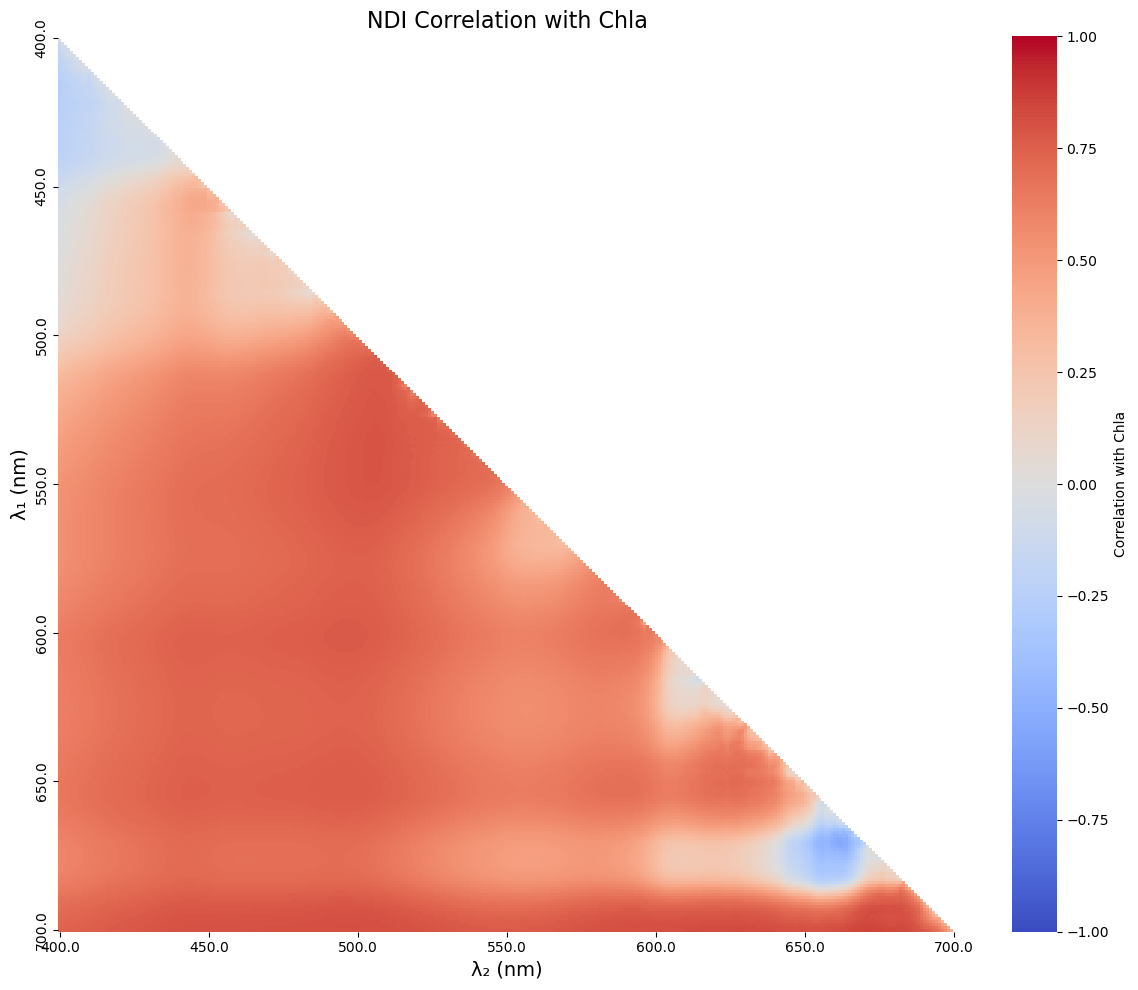

In [7]:
# Get all reflectance bands
wavelengths = [col for col in df.columns if isinstance(col, float)]
wavelengths = sorted(wavelengths)
rrs = df[wavelengths]
rrs = rrs.clip(lower=0, upper=0.1)

if log:
    target = np.log(df[param].clip(lower=1e-4))
else:
    target = df[param].clip(lower=1e-4)

# Prepare NDI correlation matrix
ndi_corr = pd.DataFrame(index=wavelengths, columns=wavelengths, dtype=float)

# Compute correlation for each band pair (only upper triangle + diagonal excluded)
for i, wl1 in enumerate(wavelengths):
    for j, wl2 in enumerate(wavelengths):
        if wl1 == wl2:
            continue  # Skip diagonal
        ndi = (rrs[wl1] - rrs[wl2]) / (rrs[wl1] + rrs[wl2])
        ndi_corr.at[wl1, wl2] = ndi.corr(target)

# Create a mask for the upper triangle (optional)
mask = np.triu(np.ones_like(ndi_corr, dtype=bool))

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(ndi_corr.astype(float), cmap='coolwarm', center=0,
            mask=mask | ndi_corr.isna().values,
            vmin=-1, vmax=1,  # Set correlation scale limits here
            cbar_kws={'label': 'Correlation with ' + param},
            xticklabels=50, yticklabels=50)

# Adjust labels and title
plt.title(f"NDI Correlation with {param}", fontsize=16)
plt.xlabel("λ₂ (nm)", fontsize=14)
plt.ylabel("λ₁ (nm)", fontsize=14)
plt.tight_layout()
plt.show()

Cool, cool. We're kind of eye-balling it at this point, so let's sort out what the 5 best combos were. It is likely that the first 5 combinations will be very close to one another due to cross-correlation of the nearby color bands, so you are welcome to put out a hundred values if you'd like. It'll just be a ltitle messy. 

In [8]:
# === Find top 5 NDI correlations ===
# Flatten the correlation matrix and drop NaNs
ndi_flat = ndi_corr.stack().dropna()

# Sort by absolute correlation
top_5_ndi = ndi_flat.reindex(ndi_flat.abs().sort_values(ascending=False).index).head(5)

# Print the results
print(f"\nTop 5 NDI band combinations by absolute correlation with {param}:")
for (wl1, wl2), corr in top_5_ndi.items():
    print(f"λ₁ = {int(wl1)} nm, λ₂ = {int(wl2)} nm --> r = {corr:.4f}")



Top 5 NDI band combinations by absolute correlation with Chla:
λ₁ = 700 nm, λ₂ = 671 nm --> r = 0.8520
λ₁ = 671 nm, λ₂ = 700 nm --> r = -0.8520
λ₁ = 672 nm, λ₂ = 700 nm --> r = -0.8519
λ₁ = 700 nm, λ₂ = 672 nm --> r = 0.8519
λ₁ = 700 nm, λ₂ = 670 nm --> r = 0.8514


# How did we do?

Alright, then. Let's take the top choice and visualize how well it correlates with your parameter with a good old fashined scatter plot. Because this is biogeochemical data, let's go out on a limb here and assume that mayhaps our relationship will not necessarily be linear. That's fine, we used the correlation analysis above to get an idea of the hot spots. Here, we'll do linear fit, and then use the same two band NDI combination to fit a n^{th} degree polynomial, and see which fits better.

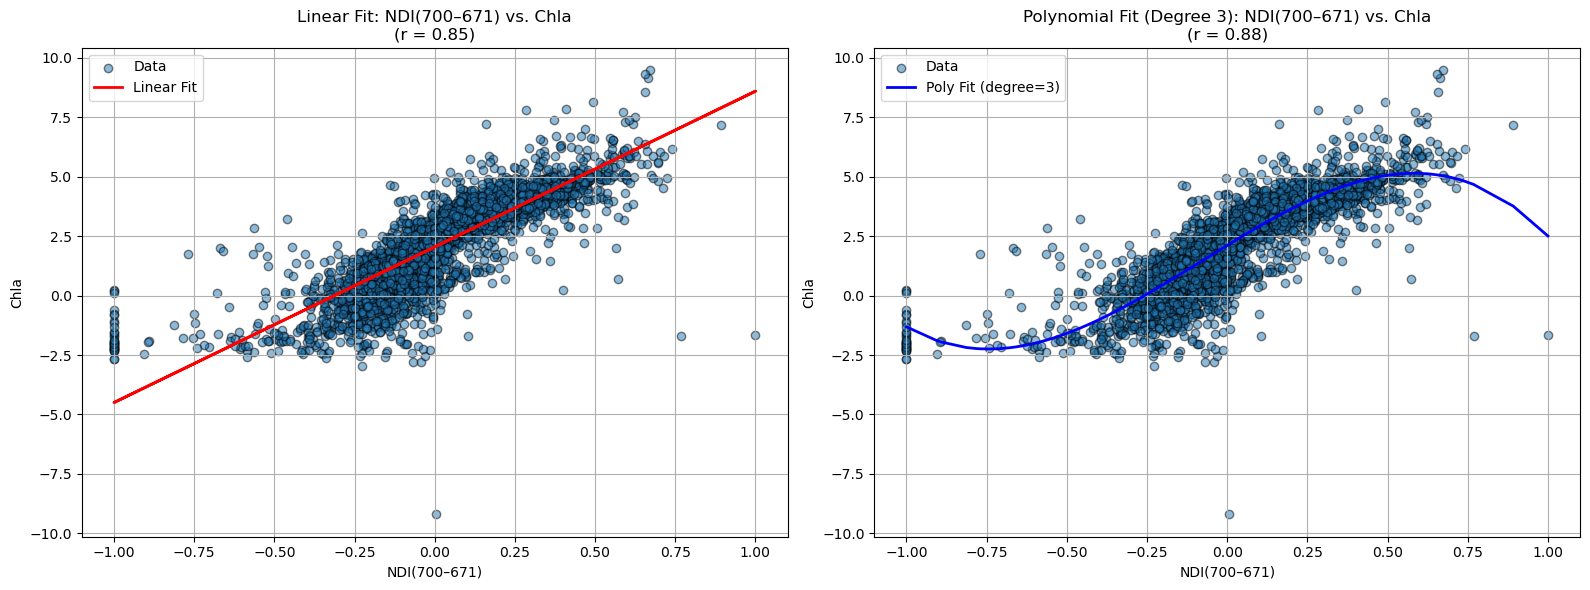

In [9]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Extract top band pair and its correlation
(wl1, wl2), top_corr = list(top_5_ndi.items())[0]

# Compute NDI
ndi = (rrs[wl1] - rrs[wl2]) / (rrs[wl1] + rrs[wl2])
ndi = ndi.replace([np.inf, -np.inf], np.nan).dropna()
parameter = target.loc[ndi.index]

# Prepare data for linear regression
X = ndi.values.reshape(-1, 1)
y = parameter.values
model_linear = LinearRegression().fit(X, y)
y_pred_linear = model_linear.predict(X)

# Prepare polynomial regression (nth order)
degree = 3  # Change this to adjust polynomial order
poly = PolynomialFeatures(degree=degree, include_bias=False)
X_poly = poly.fit_transform(X)
model_poly = LinearRegression().fit(X_poly, y)
y_pred_poly = model_poly.predict(X_poly)
r_poly = np.corrcoef(y, y_pred_poly)[0, 1]

# === Sort NDI for smooth polynomial line ===
ndi_sorted = np.sort(ndi.values)
X_sorted = ndi_sorted.reshape(-1, 1)
X_poly_sorted = poly.transform(X_sorted)
y_poly_sorted = model_poly.predict(X_poly_sorted)

# Create figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# === Plot 1: Linear Fit ===
axs[0].scatter(ndi, parameter, alpha=0.5, edgecolor='k', label='Data')
axs[0].plot(ndi, y_pred_linear, color='red', linewidth=2, label='Linear Fit')
axs[0].set_title(f"Linear Fit: NDI({int(wl1)}–{int(wl2)}) vs. {param}\n(r = {top_corr:.2f})")
axs[0].set_xlabel(f"NDI({int(wl1)}–{int(wl2)})")
axs[0].set_ylabel(f"{param}")
axs[0].legend()
axs[0].grid(True)

# === Plot 2: Polynomial Fit (sorted x for smooth curve) ===
axs[1].scatter(ndi, parameter, alpha=0.5, edgecolor='k', label='Data')
axs[1].plot(ndi_sorted, y_poly_sorted, color='blue', linewidth=2, label=f'Poly Fit (degree={degree})')
axs[1].set_title(f"Polynomial Fit (Degree {degree}): NDI({int(wl1)}–{int(wl2)}) vs. {param}\n(r = {r_poly:.2f})")
axs[1].set_xlabel(f"NDI({int(wl1)}–{int(wl2)})")
axs[1].set_ylabel(f"{param}")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [10]:
# Print linear fit equation
slope = model_linear.coef_[0]
intercept = model_linear.intercept_
print(f"Linear Fit Equation:\n{param} = {slope:.4f} * NDI({int(wl1)},{int(wl2)}) + {intercept:.4f}\n")

#Print polynomial fit equation
coefs = model_poly.coef_
intercept_poly = model_poly.intercept_
terms = [f"{coefs[i]:.4f} * NDI^{i+1}" for i in range(len(coefs))]
equation_poly = " + ".join(terms) + f" + {intercept_poly:.4f}"
print(f"Polynomial Fit Equation (degree {degree}):\n{param} = {equation_poly}\n")


Linear Fit Equation:
Chla = 6.5504 * NDI(700,671) + 2.0507

Polynomial Fit Equation (degree 3):
Chla = 8.2315 * NDI^1 + -1.5207 * NDI^2 + -6.3192 * NDI^3 + 2.1172



# Unimpressed? That's alright. Data has no feelings... or does it?

Hmmmm, did any of this pan out for you? Maybe so. You may be an ocean modeler and you are absolutely beside yourself that we arrived at a correlation of 0.6!?! Unheard of! Or perhaps you come from a chemistry background, went through this little exercise, and have now concluded that all ocean color science is 100% irrelevant fake science, and nothing will ever change your mind on this matter. Either way, there is more to do! What we just went through was a means of trying to find a first order relationship based on empirical data, but we made some parametric assumptions along the way (which may not be valid). What if, we let the machines do some heavy lifting? Let's try out a few basic machine learning techniques to see if we can do any better in terms of performance. 

# KNN (K-Nearest Neighbors)

This is a relatively simplistic machine learning algorithm used to predict something based on the values of its nearest "look-alike" in a training dataset. Here's the skinny on the mechanics:

> 1. Distnace calulation - KNN first calculates the distance between a new data point and all the training data points
> 2. It then identifies the "K" nearest neighbors to the new data point based on the calculated distances
> 3. It then predicts the value of the new data point by averaging the values of of the K nearest neighbors.

In this, you define K, which is the number of nearest neighbors to consider. A large K can make smoother predictions but mask local variations in the data, while a smaller K can be more sensitve to noise and outliers. This approach can be particularly effective if we are dealing with a small dataset (by remote sensing standards, our dataset it pretty small), as more complex models will be more prone to overfitting. 

Let's start by getting everything set up. We're going to get everything into X and y terms, just to simplify, but in this instance, X = hyperspectral reflectance and y = our parameter of interest.

In [11]:
df = datasets[param]
rrs_cols = [col for col in df.columns if isinstance(col, float) and 400 <= col <= 700]
X = df[rrs_cols].values
y = df[param].values

# Create a mask for valid target values, just to take out NaNs and zeros and things that confuse models
valid_mask = y > 0
# Filter X and y
X = X[valid_mask]
y = y[valid_mask]
# Filter out rows with NaNs in X
valid_input = ~np.isnan(X).any(axis=1)
X = X[valid_input]
y = y[valid_input]

# Log-transform target if you specified so earlier
if log:
    y = np.log10(y)


# Optional: Normalize spectra
from sklearn.preprocessing import StandardScaler
if norm:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We're going to standardize our data right quick. 

*scaler:* 
This creates a scaler object that will standardize your data. Standardization means scaling the data so it has a mean of 0 and a standard deviation of 1. It’s important when dealing with machine learning models because many models perform better when the input data is on the same scale.

*scaler.fit_transform(X):*
*fit():* 
This step calculates the mean and standard deviation of each feature (column) in your dataset X. It does this for each feature individually.
*transform():* 
After fitting, it scales each feature by subtracting the mean and dividing by the standard deviation. This process ensures that each feature has a mean of 0 and a standard deviation of 1.

In [12]:
from sklearn.preprocessing import StandardScaler
if norm:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

Now let's divvy up our data into separate test and training datesets. Here we define test_size=0.2 to denote that we'll be reserving 20% of the data to test out our model, and the other 80% will be used to train it. The random state can be set to any number, but here we're guaranteeing that the data is split exactly the same way every time you run the model, which is helpful for consistency and debugging.

In [13]:
# Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

This is the knn regression itself being run. If you want to adjust the number of "neighbors" (see above), here is the place to do so. 

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

Now let's see how it did:

KNN r: 0.9020768389714997
RMSE: 0.32730932569654825


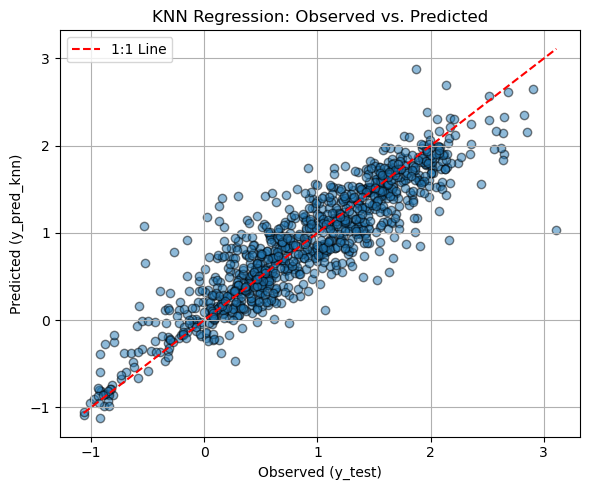

In [15]:
print("KNN r:", np.sqrt(r2_score(y_test, y_pred_knn)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))
print("RMSE:", rmse)

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_knn, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='1:1 Line')
plt.xlabel('Observed (y_test)')
plt.ylabel('Predicted (y_pred_knn)')
plt.title('KNN Regression: Observed vs. Predicted')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Random Forest Regression

Let's try out another flavor. As I continuously remind my daughter, you'll never know until you try it. Try it. Just try it, please? Feel free to completely ignore me and roll your eyes as she does. Or, let's try a Random Forest regression. 

Random Forest is a supervised machine learning technique that uses an ensemble learning method for regression. It operates by constructing multiple "decision trees" during training and outputs the average of the predictions of the individual trees. It has a few steps/features that should be noted:

With this approach, we are bootstrapping, meaning the model randomly selects subsets of data with replacement to create different training sets for each tree. This ensures that each "tree" in the "forest" still sees slightly different data. To build a tree, the algorithm will try to find the best way to split the data into two subsets based on a feature. The goal is to split the data into subsets where the target variable (the thing you're trying to predict) is more homogeneous. The algorithm tests various splits (e.g., "Is Feature 1 <= 5.2?"), and it chooses the split that best reduces the uncertainty (in regression, this is based on minimizing the variance in the target variable within each subset. These trees contain a lot of conditional logic (e.g., "if feature1 <= 5.2, predict 10, else predict 20"). The "best" split is the one that produces the most pure (least variable) subsets of data, which means the target variable is as consistent as possible within each group. This goes on for some time. After the trees are built, predictions are essentially made by averaging the outputs of all the trees.

So, let's give this a spin. Wait, before we do that, let's do something to make our lives easier. This can be computationally expensive, and given the high cross-correlation between neighboring bands, how about we re-sample our hyperspectral data to 5 nm resolution instead of 1 nm? It will make things run a bit faster, and we are unlikely to miss anything critical. 


In [16]:
X_reduced = X[:, ::5]  # Every 5th band
wavelengths_reduced = np.array(rrs_cols)[::5]
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

Okay, now let's work that tree magic. Another route for efficiency here is adjusting the n_estimators, which is essentially how many trees you want to build. Hypothetically the more trees = more accuracy, but there is probably a point of diminishing returns, so you can play around with this to see what works best for your data. Let's start with a humble 50 tree forest. We'll first run the model, then make a plot showing the locations (wavelengths) deemed important by the splitting, and then a scatter plot to see how the 20% test subset performs using this trained dataset. 

RF r: 0.923308740763211
RMSE: 1.0127634851349638


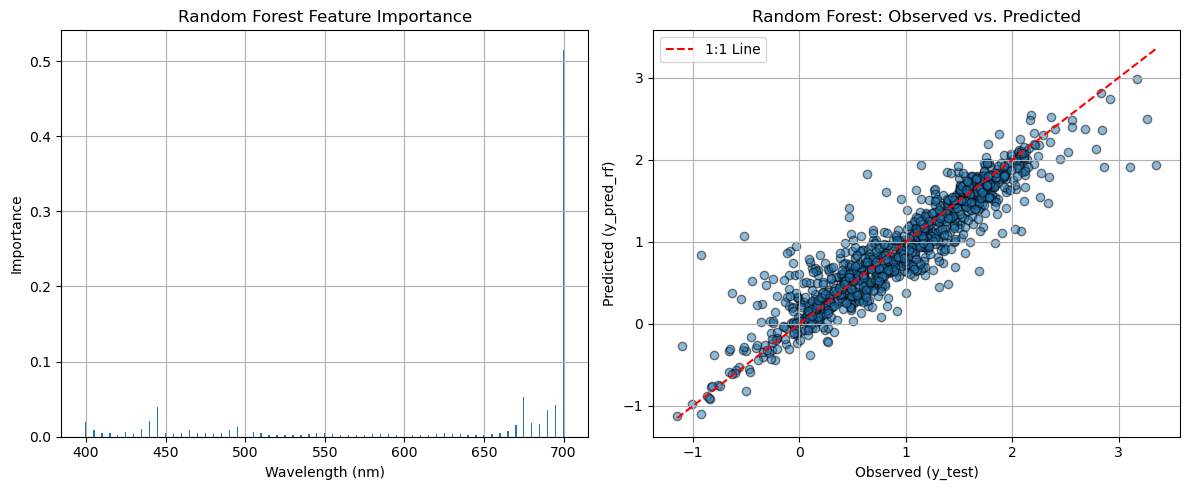

In [17]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=50, random_state=1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("RF r:", np.sqrt(r2_score(y_test, y_pred_rf)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))
print("RMSE:", rmse)

# Optional: Plot feature importances
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# --- Left plot: Feature importance ---
axs[0].bar(wavelengths_reduced, rf.feature_importances_)
axs[0].set_title("Random Forest Feature Importance")
axs[0].set_xlabel("Wavelength (nm)")
axs[0].set_ylabel("Importance")
axs[0].grid(True)

# --- Right plot: Observed vs Predicted ---
axs[1].scatter(y_test, y_pred_rf, alpha=0.5, edgecolor='k')
axs[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='1:1 Line')
axs[1].set_xlabel("Observed (y_test)")
axs[1].set_ylabel("Predicted (y_pred_rf)")
axs[1].set_title("Random Forest: Observed vs. Predicted")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# That’s a wrap! 

While we may not have answered every lingering question in the field of ocean optics today, we’ve certainly made significant progress in exploring the dataset. As you’ve probably been reminded in various parts of your professional journey, it’s important to approach machine learning with caution. Even if it no longer feels like a black box, and even with mechanisms in place to mitigate overfitting, machine learning models can still be just as susceptible to errors as simpler algorithms—yet we often assume they’re more accurate.

With that - go forth data nerd! Create algorithms with your new superpowers!